In [1]:
import numpy as np 
import pandas as pd
from scipy.optimize import minimize
import matplotlib.pylab as plt 

plt.rc('text', usetex=True)
plt.rc('font',**{'family':'sans-serif','serif':['Palatino']})
figSize  = (12, 8)
fontSize = 20

In [2]:
class FirstModel:
    def __init__(self, domain, fiducial, noisecov):

        self.domain = domain
        self.fiducial = fiducial
        self.nparam = len(fiducial)
        self.ndata = len(self.domain)
        
        # (N x p)
        self.grad1 = self.gradient(fiducial)
        
        # (N x p)
        self.bmat1 = np.linalg.inv(noisecov) @ self.grad1
        
        # (p x p)
        self.lam1 = self.bmat1.T @ noisecov @ self.bmat1
        
        # theory of size N 
        self.theory_fid_1 = self.function(self.fiducial)

    ## Example 1 

    def function(self, parameters):
        mean = parameters[0] * np.sin(parameters[1] * self.domain)
        return mean
        
    def gradient(self, parameters):
        gradient_param_0 = np.sin(parameters[1] * self.domain)
        gradient_param_1 = parameters[0] * self.domain * np.cos(parameters[1] * self.domain)
        grad = np.vstack([gradient_param_0, gradient_param_1]).T
        return grad 

    ## Example 2

#     def function(self, parameters):
#         mean = parameters[0] * self.domain**3 + parameters[1] * self.domain + parameters[2]
#         return mean
        
#     def gradient(self, parameters):
#         grad = np.vstack([self.domain**3, self.domain, np.ones(self.ndata)]).T
#         return grad 

    ## Example 3

#     def function(self, parameters):
#         mean = parameters[0] * self.domain**2 + parameters[1] * self.domain
#         return mean
        
#     def gradient(self, parameters):
#         grad = np.vstack([self.domain**2, self.domain]).T
#         return grad 

In [3]:
class SecondModel(FirstModel):
    
    def __init__(self, domain, fiducial1, fiducial2, noisecov):
        
        self.domain = domain 
        self.fiducial = fiducial2
        self.nparam = len(fiducial2)
        
        # the first model
        self.first_model = FirstModel(domain, fiducial1, noisecov)
        
        assert self.first_model.nparam >= self.nparam, 'Model 1 should have atleast the same number of parameters as Model 2'
        
        # (N x m)
        self.grad2 = self.gradient(self.fiducial)
        
        # new B matrix 
        self.bmat2 = self.grad2.T @ self.first_model.bmat1 @ np.linalg.inv(self.first_model.lam1)
        
        # (m x m)
        self.lam2 = self.bmat2 @ self.first_model.bmat1.T @ self.grad2
        
        # theory of size N 
        self.theory_fid_2 = self.function(self.fiducial) 
        
    def function(self, parameters):
        mean = parameters[0] * self.domain**3 + parameters[1] * self.domain
        return mean
    
    def gradient(self, parameters):
        grad = np.vstack([self.domain**3, self.domain]).T
        return grad

In [4]:
def evidence_full_data(data, cov_data, comp_data, comp_cov, cov_prior):
    invterm = np.linalg.inv(comp_cov + np.linalg.inv(cov_prior))
    det1 = np.linalg.slogdet(2.0 * np.pi * invterm)[1]
    det2 = np.linalg.slogdet(2.0 * np.pi * cov_data)[1]
    det3 = np.linalg.slogdet(2.0 * np.pi * cov_prior)[1]
    chi2_1 = data @ np.linalg.inv(cov_data) @ data
    chi2_2 = comp_data @ invterm @ comp_data
    evidence = 0.5 * (det1 - det2 - det3 - chi2_1 + chi2_2)
    return evidence

In [5]:
def evidence_comp_data_1(comp_data, comp_cov, cov_prior):
    invterm = np.linalg.inv(comp_cov + np.linalg.inv(cov_prior))
    det1 = np.linalg.slogdet(2.0 * np.pi * invterm)[1]
    det2 = np.linalg.slogdet(2.0 * np.pi * comp_cov)[1]
    det3 = np.linalg.slogdet(2.0 * np.pi * cov_prior)[1]
    chi2_1 = comp_data @ np.linalg.inv(comp_cov) @ comp_data
    chi2_2 = comp_data @ invterm @ comp_data
    evidence = 0.5 * (det1 - det2 - det3 - chi2_1 + chi2_2)
    return evidence

In [6]:
def evidence_comp_data_2(comp_data1, comp_data2, comp_cov1, comp_cov2, cov_prior):
    invterm = np.linalg.inv(comp_cov2 + np.linalg.inv(cov_prior))
    det1 = np.linalg.slogdet(2.0 * np.pi * invterm)[1]
    det2 = np.linalg.slogdet(2.0 * np.pi * comp_cov1)[1]
    det3 = np.linalg.slogdet(2.0 * np.pi * cov_prior)[1]
    chi2_1 = comp_data1 @ np.linalg.inv(comp_cov1) @ comp_data1
    chi2_2 = comp_data2 @ invterm @ comp_data2
    evidence = 0.5 * (det1 - det2 - det3 - chi2_1 + chi2_2)
    return evidence

In [43]:
class EvidenceAndBF:
    
    def __init__(self, domain, fiducial1, fiducial2, noisecov, covprior1, covprior2):
        
        self.noisecov = noisecov
        self.invnoise = np.linalg.inv(noisecov)
        
        self.covprior1 = covprior1
        self.covprior2 = covprior2
    
        self.models = SecondModel(domain, fiducial1, fiducial2, noisecov)
        # self.delta_mu = np.zeros(len(domain))
        self.delta_mu = self.models.first_model.theory_fid_1 - self.models.theory_fid_2
        self.delta_ys = self.models.first_model.bmat1.T @ self.delta_mu
        
    def calculations(self, data):
        
        capital_x1 = data - self.models.first_model.theory_fid_1
        capital_x2 = capital_x1 + self.delta_mu
        capital_y1 = self.models.first_model.bmat1.T @ capital_x1
        capital_y2 = capital_y1 + self.delta_ys
        capital_By2 = self.models.bmat2 @ capital_y2
        
        # uncompressed 
        evidence_1 = evidence_full_data(capital_x1, self.noisecov, capital_y1, self.models.first_model.lam1, self.covprior1)
        evidence_2 = evidence_full_data(capital_x2, self.noisecov, capital_By2, self.models.lam2, self.covprior2)

        # evidence for the compressed data 
        comp_evi_1 = evidence_comp_data_1(capital_y1, self.models.first_model.lam1, self.covprior1)
        comp_evi_2 = evidence_comp_data_2(capital_y2, capital_By2, self.models.first_model.lam1, self.models.lam2, self.covprior2)
        
        
        # record all quantities 
        record = dict()
        record['evi_full_1'] = evidence_1
        record['evi_full_2'] = evidence_2
        record['evi_comp_1'] = comp_evi_1
        record['evi_comp_2'] = comp_evi_2
        record['bf_full'] = evidence_1 - evidence_2
        record['bf_comp'] = comp_evi_1 - comp_evi_2
        
        return record 

In [44]:
sigma = 0.2
ndata = 100
minx = 0.0 
maxx = np.pi 
prior_width = 10.0 
ntrials = 5000

## For Example 1 
fid1 = [4.0, 0.75] 
fid2 = [-0.2, 3.0] 

## For Example 2 
# fid1 = [-0.5, 2.0, 0.5] 
# fid2 = [-1.0, 4.0]

## For Example 3 
# fid1 = [-1.0, 4.0]
# fid2 = [-1.0, 4.0]

nparam1 = len(fid1)
nparam2 = len(fid2)

prior_cov_1 = prior_width * np.eye(nparam1)
prior_cov_2 = prior_width * np.eye(nparam2)

domain = np.linspace(minx, maxx, ndata)
noise_cov = np.diag(np.ones(ndata)*sigma**2)

## Labels for Example 1
label_model_1 = r'$A\,\textrm{sin}\omega t$'
label_model_2 = r'$at^{3}+bt$'

## Labels for Example 2
# label_model_1 = r'$at^{3}+bt+c$'
# label_model_2 = r'$pt^{3}+qt$'

## Labels for Example 3
# label_model_1 = r'$at^{2}+bt$'
# label_model_2 = r'$pt^{3}+qt$'

### Single Experiment

In [45]:
def log_likelihood(parameters, data, domain, fid1, fid2, covariance, option=1):
    model = SecondModel(domain, fid1, fid2, covariance)
    if option == 1:
        theory = model.first_model.function(parameters)
    else:
        theory = model.function(parameters)
    diff = data - theory 
    return -0.5*diff @ np.linalg.inv(covariance) @ diff

nll = lambda *args: -log_likelihood(*args)

In [46]:
evidence_bf = EvidenceAndBF(domain, fid1, fid2, noise_cov, prior_cov_1, prior_cov_2)
data = evidence_bf.models.first_model.theory_fid_1 + sigma*np.random.randn(ndata)

In [47]:
soln_1 = minimize(nll, fid1, args=(data, domain, fid1, fid2, noise_cov, 1))
soln_2 = minimize(nll, fid2, args=(data, domain, fid1, fid2, noise_cov, 2))

In [48]:
soln_1.x

array([4.04044479, 0.75764885])

In [49]:
soln_2.x

array([-0.21098162,  2.89386026])

### Update the Fiducial Points

In [50]:
fid1 = soln_1.x
fid2 = soln_2.x
evidence_bf = EvidenceAndBF(domain, fid1, fid2, noise_cov, prior_cov_1, prior_cov_2)

In [51]:
evidence_bf.calculations(data)

{'evi_full_1': 13.12314685121107,
 'evi_full_2': 3.6531329693868035,
 'evi_comp_1': -21.75316806003847,
 'evi_comp_2': -22.915384319786213,
 'bf_full': 9.470013881824267,
 'bf_comp': 1.1622162597477441}

In [ ]:
# {'evi_full_1': 5.9773886988790315,
#  'evi_full_2': -1.2133828805285356,
#  'evi_comp_1': -21.67452019109978,
#  'evi_comp_2': -22.876995061070843,
#  'bf_full': 7.190771579407567,
#  'bf_comp': 1.2024748699710628}

# Exact Evidence

Execute only when we have two polynomials

In [35]:
def exact_evidence(data, noise_cov, gradient, covprior):
    invnoise = np.linalg.inv(noise_cov)
    prod1 = gradient.T @ invnoise @ gradient 
    prod2 = gradient.T @ invnoise @ data
    invterm = np.linalg.inv(prod1 + np.linalg.inv(covprior))
    det1 = np.linalg.slogdet(2.0 * np.pi * invterm)[1]
    det2 = np.linalg.slogdet(2.0 * np.pi * noise_cov)[1]
    det3 = np.linalg.slogdet(2.0 * np.pi * covprior)[1]
    chi2_1 = data @ invnoise @ data
    chi2_2 = prod2.T @ invterm @ prod2
    evidence = 0.5 * (det1 - det2 - det3 - chi2_1 + chi2_2)
    return evidence

In [36]:
# polynomial = False
# if polynomial: 

#     grad1 = np.vstack([domain**3, domain, np.ones(len(domain))]).T
#     grad2 = np.vstack([domain**3, domain]).T
#     theory_fid_1 = fid1[0]*domain**3 + fid1[1] * domain + fid1[2]
#     theory_fid_2 = fid2[0]*domain**3 + fid2[1] * domain
#     X1 = data - theory_fid_1
#     X2 = X1 + (theory_fid_1 - theory_fid_2)
#     evi1 = exact_evidence(X1, noise_cov, grad1, prior_cov_1)
#     evi2 = exact_evidence(X2, noise_cov, grad2, prior_cov_2)
    
#     print(f'log-evidence for Model 1 is {evi1:.3f}')
#     print(f'log-evidence for Model 2 is {evi2:.3f}')

### Plot of an example of data

In [37]:
grid = np.linspace(minx, maxx, 1000)
theory_1 = FirstModel(grid, fid1, 1E-5*np.eye(1000)).function(fid1)
theory_2 = SecondModel(grid, fid1, fid2, 1E-5*np.eye(1000)).function(fid2)

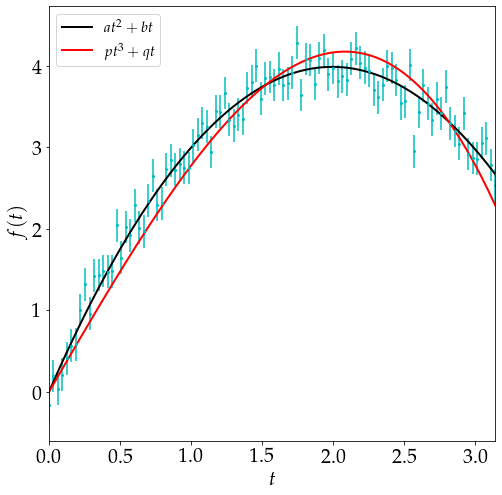

In [38]:
plt.figure(figsize=(8,8))
plt.errorbar(domain, data, yerr=sigma, fmt = 'co', markersize = 2)
plt.plot(grid, theory_1, lw = 2, c = 'k', label = label_model_1)
plt.plot(grid, theory_2, lw = 2, c = 'r', label = label_model_2)
plt.xlim(minx, maxx)
plt.xlabel(r'$t$', fontsize = fontSize)
plt.ylabel(r'$f(t)$', fontsize = fontSize)
plt.tick_params(axis='x', labelsize=fontSize)
plt.tick_params(axis='y', labelsize=fontSize)
plt.legend(loc = 'best',prop={'family':'sans-serif', 'size':15})
# plt.savefig('results/data.pdf', bbox_inches = 'tight')
# plt.savefig('results/data.png', bbox_inches = 'tight')
plt.show()

### Repeated Experiments

In [248]:
store_quantities = list()
for i in range(ntrials):
    data = evidence_bf.models.first_model.theory_fid_1 + sigma*np.random.randn(ndata)
    calculations = evidence_bf.calculations(data)
    store_quantities.append(calculations)

In [249]:
dataframe = pd.DataFrame(store_quantities)

In [250]:
dataframe.head()

,evi_full_1,evi_full_2,evi_comp_1,evi_comp_2,bf_full,bf_comp
0,0.660751,-5.821189,-21.635270,-22.857558,6.481939,1.222288
1,9.317743,6.125880,-21.635267,-22.857573,3.191863,1.222306
2,9.355336,1.926087,-21.635307,-22.857624,7.429249,1.222317
3,-1.676371,-19.157960,-21.635286,-22.857549,17.481588,1.222263
4,5.969439,-1.707449,-21.635268,-22.857542,7.676889,1.222274


## Plots

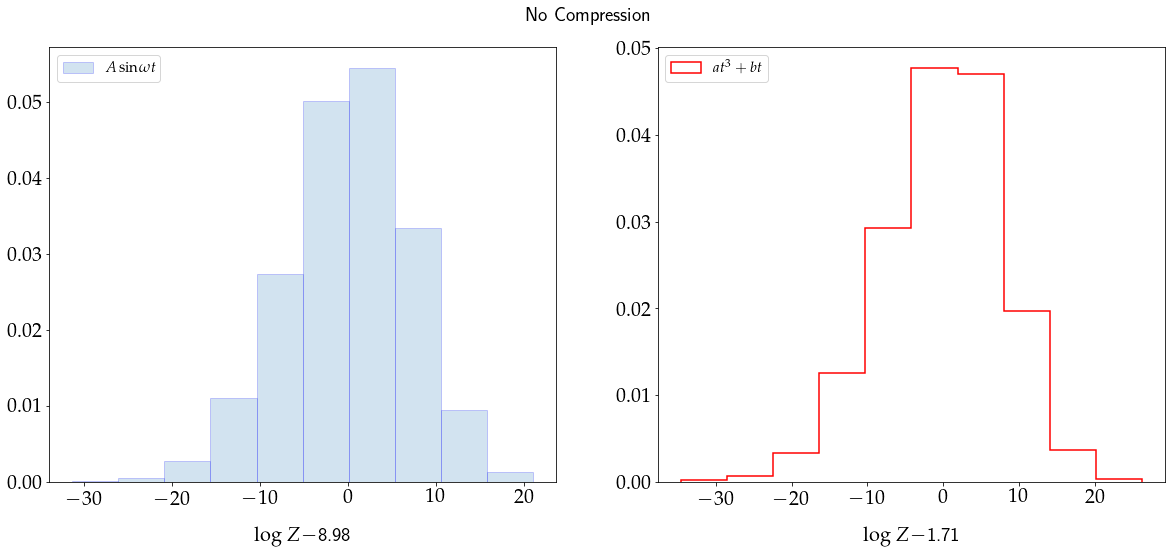

In [251]:
max_first = np.mean(dataframe['evi_full_1'].values)
max_second = np.mean(dataframe['evi_full_2'].values)

plt.figure(figsize = (20,8))
plt.suptitle('No Compression', fontsize = fontSize, y=0.95)
plt.subplot(121)
plt.hist(dataframe['evi_full_1'].values - max_first, density = True, edgecolor='b', linewidth=1.0, label = label_model_1, alpha = 0.2)
plt.xlabel(r'$\textrm{log }Z-$' + f'{abs(max_first):.2f}', fontsize = fontSize, labelpad=20)
plt.tick_params(axis='x', labelsize=fontSize)
plt.tick_params(axis='y', labelsize=fontSize)
# plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
# plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
plt.legend(loc = 'upper left',prop={'family':'sans-serif', 'size':15})

plt.subplot(122)
plt.hist(dataframe['evi_full_2'].values - max_second, density = True, edgecolor='r', linewidth=1.5, label = label_model_2, histtype='step')
plt.xlabel(r'$\textrm{log }Z-$' + f'{abs(max_second):.2f}', fontsize = fontSize, labelpad=20)
plt.tick_params(axis='x', labelsize=fontSize)
plt.tick_params(axis='y', labelsize=fontSize)
# plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
# plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
plt.legend(loc = 'upper left',prop={'family':'sans-serif', 'size':15})

# plt.savefig('results/evidence_comp_data.pdf', bbox_inches = 'tight')
# plt.savefig('results/evidence_comp_data.png', bbox_inches = 'tight')
plt.show()

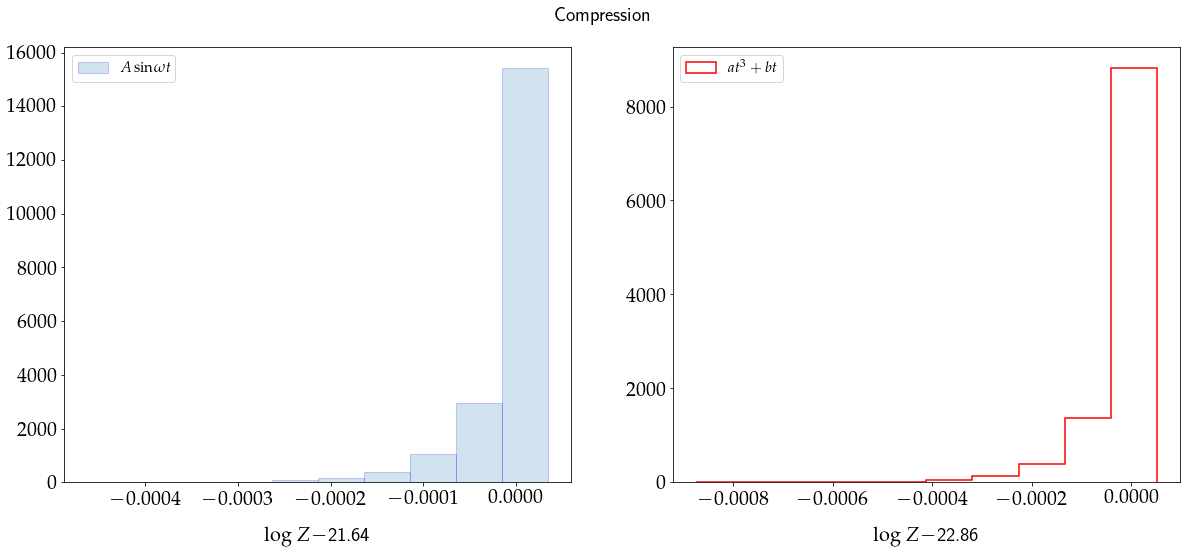

In [252]:
max_comp_first = np.mean(dataframe['evi_comp_1'].values)
max_comp_second = np.mean(dataframe['evi_comp_2'].values)

plt.figure(figsize = (20,8))
plt.suptitle('Compression', fontsize = fontSize, y=0.95)
plt.subplot(121)
plt.hist(dataframe['evi_comp_1'].values - max_comp_first, density = True, edgecolor='b', linewidth=1.0, label = label_model_1, alpha = 0.2)
plt.xlabel(r'$\textrm{log }Z-$' + f'{abs(max_comp_first):.2f}', fontsize = fontSize, labelpad=20)
plt.tick_params(axis='x', labelsize=fontSize)
plt.tick_params(axis='y', labelsize=fontSize)
# plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
# plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
plt.legend(loc = 'upper left',prop={'family':'sans-serif', 'size':15})

plt.subplot(122)
plt.hist(dataframe['evi_comp_2'].values - max_comp_second, density = True, edgecolor='r', linewidth=1.5, label = label_model_2, histtype='step')
plt.xlabel(r'$\textrm{log }Z-$' + f'{abs(max_comp_second):.2f}', fontsize = fontSize, labelpad=20)
plt.tick_params(axis='x', labelsize=fontSize)
plt.tick_params(axis='y', labelsize=fontSize)
# plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
# plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
plt.legend(loc = 'upper left',prop={'family':'sans-serif', 'size':15})

# plt.savefig('results/evidence_comp_data.pdf', bbox_inches = 'tight')
# plt.savefig('results/evidence_comp_data.png', bbox_inches = 'tight')
plt.show()

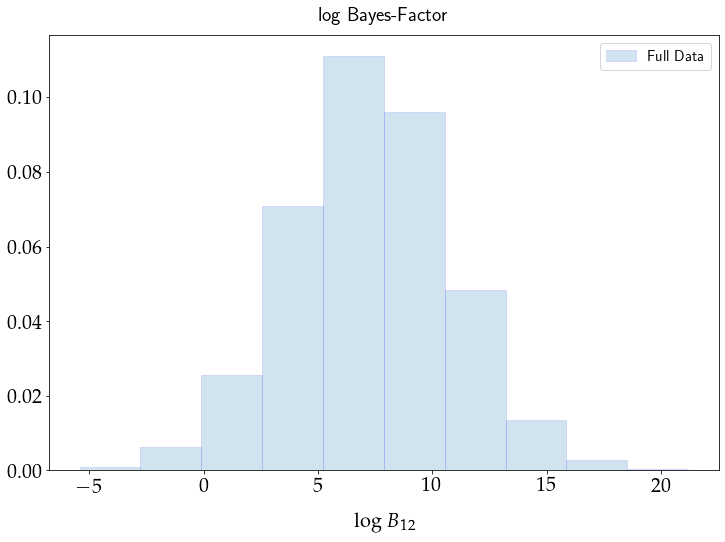

In [253]:
plt.figure(figsize = (12,8))
plt.title('log Bayes-Factor', fontsize=fontSize, y=1.02)
plt.hist(dataframe['bf_full'].values, density = True, edgecolor='b', linewidth=0.5, label = 'Full Data', alpha = 0.2)
# plt.hist(dataframe['bf_comp'].values, density = True, edgecolor='r', linewidth=1.5, label = 'Compressed Data', histtype='step')
plt.xlabel(r'$\textrm{log }B_{12}$', fontsize = fontSize, labelpad=20)
plt.tick_params(axis='x', labelsize=fontSize)
plt.tick_params(axis='y', labelsize=fontSize)
# plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
# plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
plt.legend(loc = 'upper right',prop={'family':'sans-serif', 'size':15})
# plt.savefig('results/log-bayes-factor.pdf', bbox_inches = 'tight')
# plt.savefig('results/log-bayes-factor.png', bbox_inches = 'tight')
plt.show()

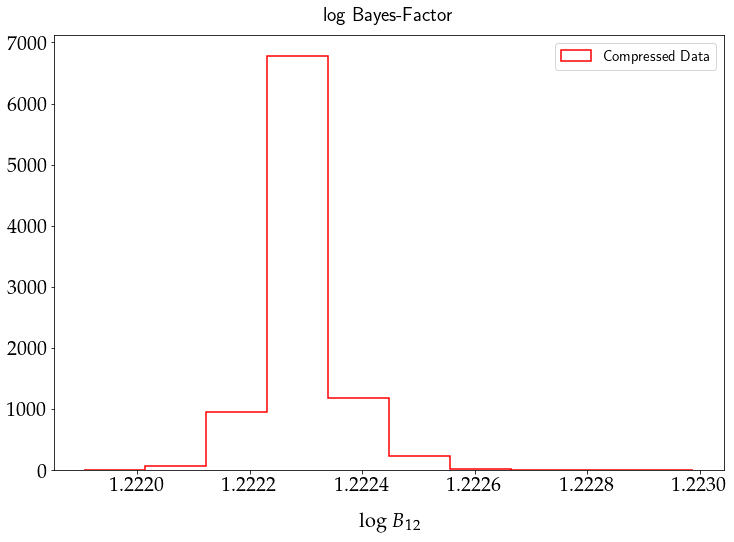

In [254]:
plt.figure(figsize = (12,8))
plt.title('log Bayes-Factor', fontsize=fontSize, y=1.02)
# plt.hist(dataframe['bf_full'].values, density = True, edgecolor='b', linewidth=0.5, label = 'Full Data', alpha = 0.2)
plt.hist(dataframe['bf_comp'].values, density = True, edgecolor='r', linewidth=1.5, label = 'Compressed Data', histtype='step')
plt.xlabel(r'$\textrm{log }B_{12}$', fontsize = fontSize, labelpad=20)
plt.tick_params(axis='x', labelsize=fontSize)
plt.tick_params(axis='y', labelsize=fontSize)
# plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
# plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
plt.legend(loc = 'upper right',prop={'family':'sans-serif', 'size':15})
# plt.savefig('results/log-bayes-factor.pdf', bbox_inches = 'tight')
# plt.savefig('results/log-bayes-factor.png', bbox_inches = 'tight')
plt.show()

In [28]:
std_bf = np.std(dataframe['bf_comp'].values)
mean_bf = np.mean(dataframe['bf_comp'].values)

print(f'The mean of the log Bayes-Factor distribution is  : {mean_bf:.3f}')
print(f'The width of the log Bayes-Factor distribution is : {std_bf:.3f}')

The mean of the log Bayes-Factor distribution is  : 1.128
The width of the log Bayes-Factor distribution is : 0.000


In [29]:
# sigma = 0.5, ndata = 100
# The mean of the log Bayes-Factor distribution is  : 0.822
# The width of the log Bayes-Factor distribution is : 0.017

# sigma = 0.5, ndata = 200
# The mean of the log Bayes-Factor distribution is  : 0.789
# The width of the log Bayes-Factor distribution is : 0.012
    
# sigma = 1.0, ndata = 100
# The mean of the log Bayes-Factor distribution is  : 1.023
# The width of the log Bayes-Factor distribution is : 0.055

# sigma = 1.0, ndata = 200
# The mean of the log Bayes-Factor distribution is  : 0.702
# The width of the log Bayes-Factor distribution is : 0.026